In [ ]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import csv
import re
import math
import numpy as np
import pandas as pd


In [ ]:
# Mounts google drive.
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Clay/BabyLM/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def corr(pattern, utt_col='object', col_lst=[8, 9, 10, 11], my_path=path+'transcripts.csv'):
    """
    Returns Pearson correlation coefficient of binary application of regex in utterance vs in saliency columns.

    Args:
      pattern (str): regex pattern to match.
      col_list (list): an optional list of saliency columns to check.
      my_path (int): an optional path to the csv file.

    Returns:
      float: Pearson correlation coefficient.
    """

    prog = re.compile(pattern) # Compiles regex pattern for future use.
    utt = [] # List of occurences of pattern in utterances
    sal = [] # List of occurences of pattern in saliency columns
    utt_num = 7 if utt_col == 'object' else 5

    file = open(my_path, 'r')
    csv_reader = csv.reader(file)
    next(csv_reader) # Skips first row.

    for i, row in enumerate(csv_reader):
        if row[6] == 'S':
            continue

        if row[2] not in list(map(str, list(range(26)))):
            continue

        if not row[utt_num]:
            continue

        # Adds 0 or 1 to utterances list if regex applies to utterance column.
        utt.append(1 if prog.search(row[utt_num]) else 0)

        # Adds 0 or 1 to saliency list if regex applies to any saliency column.
        sal.append(1 if any(map(lambda x: prog.search(x), [row[j] for j in col_lst])) else 0)

    correlation = np.corrcoef(utt, sal)[0, 1] # Gets Pearson correlation coefficient using Numpy.

    file.close()

    return correlation


In [ ]:
def occurs(pattern, utt_col='object', col_lst=[8, 9, 10, 11], my_path=path+'transcripts.csv'):
    """
    Returns tuple of frequency of regex pattern in utterances column, saliency columns, and the intersection

    Args:
      pattern (str): regex pattern to match.
      col_list (list): an optional list of saliency columns to check.
      my_path (int): an optional path to the csv file.

    Returns:
      tuple: tuple of frequency of regex pattern in utterance column, saliency columns, and the intersection of the two cases
    """

    utt, sal, utt_given_sal = 0, 0, 0
    prog = re.compile(pattern) # Compiles regex pattern for future use.
    utt_num = 5 if utt_col == 'utterance' else 7

    file = open(my_path, 'r')
    csv_reader = csv.reader(file)
    next(csv_reader) # Skips first row.

    for i, row in enumerate(csv_reader):
        if row[6] == 'S':
            continue

        if row[2] not in list(map(str, list(range(26)))):
            continue

        if not row[utt_num]:
            continue

        # Checks if regex matches utterances and saliency columns.
        utt_match = 1 if prog.search(row[utt_num]) else 0
        sal_match = 1 if any(map(lambda x: prog.search(x), [row[j] for j in col_lst])) else 0

        # if utt_match == 1:
        #     print(row)

        utt += utt_match # Adds 1 if utt column matches.
        sal += sal_match # Adds 1 if any of sal columns matches regex.
        utt_given_sal += utt_match * sal_match # Adds 1 if both utt and sal matched.

    file.close()

    return utt, sal, utt_given_sal


In [ ]:
def gen_dict(lst, max_iter=math.inf, utt_col='object', col_lst=[8, 9, 10, 11], print_flag=False, my_path=path+'transcripts.csv'):
    """
    Returns dictionary of statistics for words in lst

    Args:
      lst (list): a list of words to get statistics for.
      max_iter (int): an optional maximum number of iterations before breaking the loop.
      col_list (list): an optional list of saliency columns to check.
      print_flag (bool): an optional flag to print items being added to dictionary.
      my_path (int): an optional path to the csv file.

    Returns:
      dict: dictionary of words with a key for each word and the value being a pair of its correlation and conditional prob.
    """

    my_dict = {}
    for i, word in enumerate(lst):
        pattern = r'(?i)'+word
        correl = round(corr(pattern, utt_col=utt_col, col_lst=col_lst, my_path=my_path), 3)
        a, b, c = occurs(pattern, utt_col=utt_col, col_lst=col_lst, my_path=my_path)
        prob1 = 0 if b==0 else round(c/b, 3)
        prob2 = 0 if a==0 else round(c/a, 3)

        if print_flag:
            print(word + '\n\tCorr:\t\t' + str(correl) + '\n\tP(utt|sal):\t' + str(prob1) + '\n\tP(sal|tt):\t' + str(prob2) + '\n')

        my_dict[word] = (correl, prob1, prob2)

        if i+1 >= max_iter:
              break

    return my_dict


In [ ]:
def print_dict(my_dict):
    """Prints dictionary in clean manner."""

    for key in my_dict:
        print(key)
        print('\tCorr:\t\t' + str(round(my_dict[key][0], 3)))
        print('\tP(utt|sal):\t' + str(round(my_dict[key][1], 3)))
        print('\tP(sal|utt):\t' + str(round(my_dict[key][2], 3)))
        print()


In [ ]:
w1 = {
    'sands?': 0.96,
    'cribs?': 0.903,
    'cars?': 0.893,
    'papers?': 0.887,
    'stairs?': 0.81,
    'puzzles?': 0.78,
    'balls?': 0.773,
    'roads?': 0.76,
    'chairs?': 0.697,
    'cats?': 0.657,
    'computers?': 0.643,
    'windows?': 0.64,
    'kitchens?': 0.59,
    'grounds?': 0.583,
    'tables?': 0.533,
    'doors?': 0.507,
    'f(oo|ee)t': 0.45,
    'floors?': 0.39,
    'toys?': 0.31,
    'baskets?': 0.283,
    'rooms?': 0.26,
    'hands?': 0.243
    }

w2 = {
    'airplanes?': 0.253333333333333,
    'apples?': 0.897777777777778,
    'backpacks?': 0.368888888888889,
    'bagels?': 0.0777777777777778,
    'balls?': 0.466666666666667,
    'balloons?': 0.324444444444444,
    'baskets?': 0.0844444444444444,
    'beds?': 0.364444444444444,
    'bells?': 0.506666666666667,
    'benc(h|hes)': 0.328888888888889,
    'bikes?': 0.0577777777777778,
    'birds?': 0.266666666666667,
    'bottles?': 0.262222222222222,
    'bowls?': 0.297777777777778,
    'brooms?': 0.64,
    'buckets?': 0.466666666666667,
    'butterfl(y|ies)': 0.742222222222222,
    'buttons?': 0.364444444444444,
    'cakes?': 0.56,
    'cameras?': 0.08,
    'cats?': 0.426666666666667,
    'chairs?': 0.573333333333333,
    'cheeses?': 0.368888888888889,
    'clocks?': 0.506666666666667,
    'coins?': 0.213333333333333,
    'cookies?': 0.262222222222222,
    'cribs?': 0.822222222222222,
    'desks?': 0.231111111111111,
    'dogs?': 0.608888888888889,
    'fans?': 0.0311111111111111,
    'guitars?': 0.12,
    'hairbrus(h|hes)': 0.0977777777777778,
    'hat': 0.631111111111111,
    'jackets?': 0.342857142857143,
    'juices?': 0.737777777777778,
    'kayaks?': 0.123809523809524,
    'keys?': 0.195555555555556,
    'kni(fe|ves)': 0.0133333333333333,
    'lea(f|ves)': 0.4,
    'microwaves?': 0.4,
    'necklaces?': 0.417777777777778,
    'pants': 0.333333333333333,
    'pens?': 0.124444444444444,
    'phones?': 0.222222222222222,
    'pipes?': 0.124444444444444,
    'pizzas?': 0.102222222222222,
    'rings?': 0.561904761904762,
    'rocks?': 0.52,
    'sandwic(h|hes)': 0.542222222222222,
    'scissors': 0.391111111111111,
    'shoes?': 0.24,
    'socks?': 0.391111111111111,
    'sofas?': 0.226666666666667,
    'spoons?': 0.168888888888889,
    'stamps?': 0.0755555555555556,
    'stools?': 0.275555555555556,
    'toothpastes?': 0.271111111111111,
    'trains?': 0.435555555555555,
    'trees?': 0.613333333333333,
    'tricycles?': 0.315555555555556,
    'turtles?': 0.506666666666667,
    'tvs?': 0.373333333333333,
    'umbrellas?': 0.177777777777778,
    'watc(h|hes)': 0.222222222222222
    }

In [ ]:
freqs = {
    'ball': 481,
    'train': 235,
    'socks': 129,
    'bottle': 110,
    'camera': 92,
    'pants': 91,
    'apple': 77,
    'watch': 73,
    'balloon': 68,
    'bucket': 59,
    'chair': 54,
    'spoon': 53,
    'crib': 51,
    'jacket': 49,
    'juice': 48,
    'bowl': 46,
    'tree': 46,
    'backpack': 44,
    'bed': 43,
    'bird': 36,
    'button': 34,
    'shoe': 34,
    'dog': 31,
    'hat': 28,
    'pen': 27,
    'leaves': 26,
    'cat': 25,
    'bike': 23,
    'butterfly': 23,
    'cake': 22,
    'guitar': 21,
    'basket': 19,
    'umbrella': 18,
    'phone': 17,
    'knife': 16,
    'bagel': 11,
    'bench': 10,
    'cheese': 10,
    'clock': 10,
    'key': 10,
    'hairbrush': 9,
    'rock': 9,
    'turtle': 9,
    'airplane': 8,
    'ring': 7,
    'sofa': 7,
    'broom': 6,
    'stool': 6,
    'bell': 5,
    'cookie': 5,
    'microwave': 5,
    'scissors': 5,
    'stamp': 5,
    'tv': 5,
    'coin': 4,
    'necklace': 4,
    'sandwich': 4,
    'toothpaste': 4,
    'desk': 3,
    'fan': 3,
    'kayak': 3,
    'pipe': 3,
    'pizza': 3,
    'tricycle': 3
    }

In [ ]:
words = w2.copy()
# words.update(w2)

In [ ]:
# MAIN

lst = list(words.keys())

utt_col='utterance'
col_lst=[8, 9, 10, 11]

my_dict = {}
my_dict['word'] = []
my_dict['corr'] = []
my_dict['utt_given_sal'] = []
my_dict['sal_given_utt'] = []
my_dict['occurs'] = []
my_dict['accuracy'] = []

for word in lst:
    pattern = r'(?i)(?<!\w)'+word+r'(?!\w)'
    correl = round(corr(pattern, utt_col=utt_col, col_lst=col_lst), 3)
    a, b, c = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
    prob1 = 0 if b==0 else round(c/b, 3)
    prob2 = 0 if a==0 else round(c/a, 3)
    my_dict['word'].append(word)
    my_dict['corr'].append(correl)
    my_dict['utt_given_sal'].append(prob1)
    my_dict['sal_given_utt'].append(prob2)
    my_dict['occurs'].append(a)
    my_dict['accuracy'].append(words[word])

df = pd.DataFrame(my_dict)
df.to_csv(path+'k_obj.csv')

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


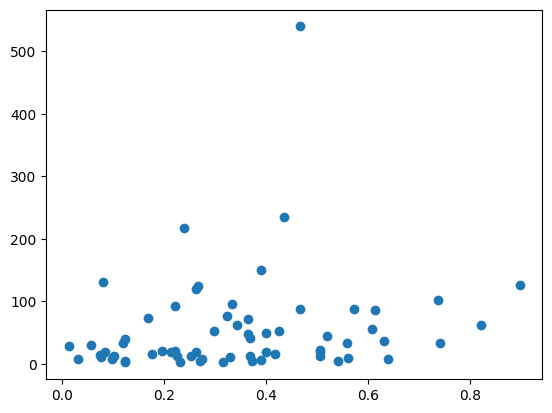

In [ ]:
import matplotlib.pyplot as plt
x = df["accuracy"]
y = df["occurs"]
plot = plt.scatter(x, y)
plt.show()


In [ ]:
utt_col='utterance'
col_lst=[8, 9, 10, 11]
my_path = '/content/drive/MyDrive/Colab Notebooks/Clay/BabyLM/transcripts.csv'

my_dict_2 = {}
my_dict_2['Utterance'] = []
my_dict_2['Word'] = []
my_dict_2['Child_Age'] = []
my_dict_2['Occurs'] = []
my_dict_2['Salient'] = []
my_dict_2['Accuracy'] = []
my_dict_2['Freq'] = []

utt_num = 5 if utt_col == 'utterance' else 7

file = open(my_path, 'r')
csv_reader = csv.reader(file)
next(csv_reader) # Skips first row.

for i, row in enumerate(csv_reader):

    if row[6] == 'S':
        continue

    if row[2] not in list(map(str, list(range(26)))):
        continue

    if not row[utt_num]:
        continue

    for word in list(w2.keys()):
        pattern = r'(?i)(?<!\w)'+word+r'(?!\w)'
        prog = re.compile(pattern)
        utt_match = 1 if prog.search(row[utt_num]) else 0
        sal_match = 1 if any(map(lambda x: prog.search(x), [row[j] for j in col_lst])) else 0

        # if not (utt_match or sal_match):
        #     continue

        my_dict_2['Utterance'].append(row[5])
        my_dict_2['Word'].append(word)
        my_dict_2['Child_Age'].append(row[2])
        my_dict_2['Occurs'].append(utt_match)
        my_dict_2['Salient'].append(sal_match)
        my_dict_2['Accuracy'].append(words[word])

        if word == "socks?":
            my_dict_2['Freq'].append(freqs["socks"])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs["socks"] != c:
                print(freqs["socks"], c)
        elif word == "lea(f|ves)":
            my_dict_2['Freq'].append(freqs["leaves"])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs["leaves"] != c:
                print(freqs["leaves"], c)
        elif word[-2:] == r's?':
            my_dict_2['Freq'].append(freqs[word[:-2]])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word[:-2]] != c:
                print(freqs[word[:-2]], c)
        elif word[-7:] == r'(h|hes)':
            my_dict_2['Freq'].append(freqs[word[:-7]+'h'])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word[:-7]+'h'] != c:
                print(freqs[word[:-7]+'h'], c)
        elif word[-7:] == r'(y|ies)':
            my_dict_2['Freq'].append(freqs[word[:-7]+'y'])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word[:-7]+'y'] != c:
                print(freqs[word[:-7]+'y'], c)
        elif word[-8:] == r'(fe|ves)':
            my_dict_2['Freq'].append(freqs[word[:-8]+'fe'])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word[:-8]+'fe'] != c:
                print(freqs[word[:-8]+'fe'], c)
        elif word[-7:] == r'(f|ves)':
            my_dict_2['Freq'].append(freqs[word[:-7]+'f'])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word[:-7]+'f'] != c:
                print(freqs[word[:-7]+'f'], c)
        else:
            my_dict_2['Freq'].append(freqs[word])
            c, _, _ = occurs(pattern, utt_col=utt_col, col_lst=col_lst)
            if freqs[word] != c:
                print(freqs[word], c)

file.close()

df = pd.DataFrame(my_dict_2)
df.to_csv(path+'large_data.csv')


Streaming output truncated to the last 5000 lines.
10 12
10 19
4 18
5 18
51 62
31 56
3 8
21 33
9 7
28 37
49 62
48 102
3 2
10 20
16 28
26 50
5 19
4 16
91 95
27 40
17 21
3 4
3 12
7 9
9 45
4 5
5 6
34 217
129 150
7 12
53 73
5 14
6 7
4 5
46 86
9 12
5 4
18 16
73 93
8 12
77 126
44 41
11 10
481 540
68 77
19 18
43 47
5 22
10 11
23 30
36 125
110 120
46 53
6 7
59 88
23 33
34 72
22 33
92 131
25 53
54 87
10 12
10 19
4 18
5 18
51 62
31 56
3 8
21 33
9 7
28 37
49 62
48 102
3 2
10 20
16 28
26 50
5 19
4 16
91 95
27 40
17 21
3 4
3 12
7 9
9 45
4 5
5 6
34 217
129 150
7 12
53 73
5 14
6 7
4 5
46 86
9 12
5 4
18 16
73 93
8 12
77 126
44 41
11 10
481 540
68 77
19 18
43 47
5 22
10 11
23 30
36 125
110 120
46 53
6 7
59 88
23 33
34 72
22 33
92 131
25 53
54 87
10 12
10 19
4 18
5 18
51 62
31 56
3 8
21 33
9 7
28 37
49 62
48 102
3 2
10 20
16 28
26 50
5 19
4 16
91 95
27 40
17 21
3 4
3 12
7 9
9 45
4 5
5 6
34 217
129 150
7 12
53 73
5 14
6 7
4 5
46 86
9 12
5 4
18 16
73 93
8 12
77 126
44 41
11 10
481 540
68 77
19 18
43 47
5 

KeyboardInterrupt: 

In [ ]:
df

,Utterance,Word,Child_Age,Occurs,Salient,Accuracy,Freq
0,I'm going to put this on your head,airplanes?,6,0,0,0.253333,8
1,I'm going to put this on your head,apples?,6,0,0,0.897778,77
2,I'm going to put this on your head,backpacks?,6,0,0,0.368889,44
3,I'm going to put this on your head,bagels?,6,0,0,0.077778,11
4,I'm going to put this on your head,balls?,6,0,0,0.466667,481
...,...,...,...,...,...,...,...
1592443,Wash your face.,tricycles?,25,0,0,0.315556,3
1592444,Wash your face.,turtles?,25,0,0,0.506667,9
1592445,Wash your face.,tvs?,25,0,0,0.373333,5
1592446,Wash your face.,umbrellas?,25,0,0,0.177778,18
